In [1]:
import numpy as np
from matplotlib import pyplot as plt

from data_generation import Three_body_2D_Rick
from data_generation import tbp_util
from data_generation.tbp_energy_calculations import visualize_dataset

# Experiment 1

Predict new x,y, vx, vy from previous. Try to predict t timesteps ahead.

Training data: ...
- number of trajectories
- precision
- trajectory length
- filter unstable

Model:
- n layers, neurons per layer
- regularization
- learning rate

Results:
- loss
- example trajectory comparison


In [2]:
experiments = {
    "Experiment_1": {
        "max_datasets": 102,
        "prediction_offset": 10,  # predict t time steps ahead
        "batch_size": 256,
        "epochs": 20,
        "validation_split": 0.1,
        "no_dense_layers": 10,
        "neurons_per_layer": 128,
        "learning_rate": 0.0001,
        "dataset": {
            "name": "breen-et-al-00001",
            # filter 1 in 10 values to reduce RAM usage
            "downsample_factor": 10,
            "dataset_index": 0
        }
    },
    "Experiment_1_2": {
        "max_datasets": 102,
        "prediction_offset": 10,  # predict t time steps ahead
        "batch_size": 256,
        "epochs": 20,
        "validation_split": 0.1,
        "no_dense_layers": 10,
        "neurons_per_layer": 128,
        "learning_rate": 0.00001,
        "dataset": {
            "name": "breen-et-al-00001",
            # filter 1 in 10 values to reduce RAM usage
            "downsample_factor": 10,
            "dataset_index": 0
        }
    }
}

In [3]:
experiment_id = "Experiment_1"
config_name = experiments[experiment_id]["dataset"]["name"]
tbp_util.use_config(config_name)

Setting breen-et-al-00001 as the configuration to load trajectories from


In [4]:
# allow autoreloading of imported modules whenever running a cell
# if not included, a kernel restart is needed whenever one of the imports is modified
# (Needs experimenting / import statements to work)
# %load_ext autoreload
# %autoreload 2

In [5]:
# todo read from config file
# also see tbp_util.py
G = 1.0
M = np.array([1.0, 1.0, 1.0])

Choose example trajectory from the data set to visualize.

In [6]:
example_dataset = "325"


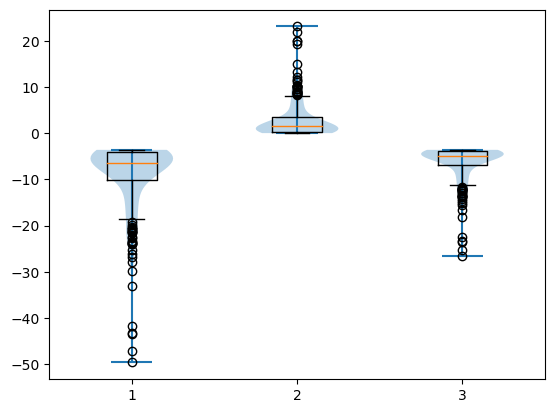

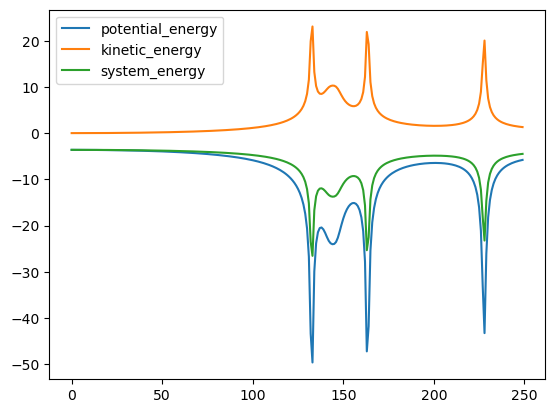

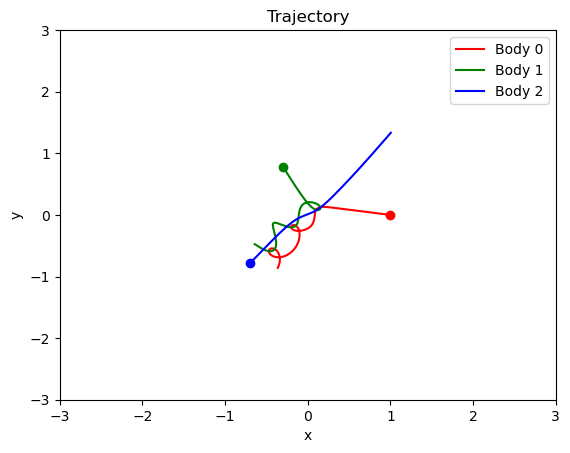

In [7]:
visualize_dataset(*tbp_util.load_dataset(example_dataset), G, M)

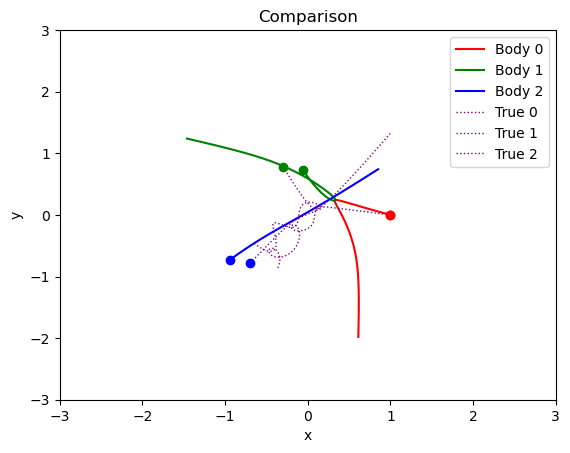

In [8]:
x, y, vx, vy = tbp_util.load_dataset(example_dataset)
x2, y2, vx, vy = tbp_util.load_dataset("323")
Three_body_2D_Rick.compare_plot(x, y, x2, y2)

In [9]:
x, y, vx, vy = tbp_util.load_dataset(example_dataset)
x[0, :]

array([ 1.        , -0.30085194, -0.69914806], dtype=float128)

In [10]:
y[0, :]

array([ 0.        ,  0.78428587, -0.78428587], dtype=float128)

In [11]:
from tensorflow import keras

keras.backend.set_floatx('float64')
keras.backend.floatx()

2023-07-01 18:31:48.645841: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'float64'

# Load training data

Load training data.
A trajectory has t timesteps. For each time step it has 12 variables:
- x, y, vx, vy for each of the 3 bodies

max_datasets: maximum number of datasets to load and train on
prediction offset: how many time steps to predict into the future
downsample factor: only use one in downsample_factor data points for training, allows for k-partition validation
dataset_index: if using a downsample factor of 10, there are 10 unique sub-datasets that can be used

In [12]:
max_datasets = experiments[experiment_id]['max_datasets']
prediction_offset = experiments[experiment_id]['prediction_offset']
downsample_factor = experiments[experiment_id]['dataset']['downsample_factor']
dataset_index = experiments[experiment_id]['dataset']['dataset_index']

x_train = np.ndarray((0, 12), dtype=np.float64)
y_train = np.ndarray((0, 12), dtype=np.float64)
for dataset, x, y, vx, vy in tbp_util.load_datasets(limit=max_datasets):
    input_data = np.column_stack((x, y, vx, vy))
    # offset trajectories to allow for k-partition cross-validation
    input_data = input_data[dataset_index:]
    output_data = input_data.copy()

    # predict t samples into the future
    input_data = input_data[:-prediction_offset:downsample_factor, ]
    output_data = output_data[prediction_offset::downsample_factor, ]

    x_train = np.concatenate((x_train, input_data))
    y_train = np.concatenate((y_train, output_data))


loaded 0 datasets


In [13]:
x_train.shape

(2524899, 12)

In [14]:
y_train.shape

(2524899, 12)

In [15]:
assert x_train.shape == y_train.shape

first training example **[ x1, x2, x3, y1, y2, y3, vx1, vx2, vx3, vy1, vy2, vy3 ]**
first testing  example **[ x1', x2', x3', y1', y2', y3', vx1', vx2', vx3', vy1', vy2', vy3' ]**

In [16]:
x_train[0,]

array([ 1.        , -0.12707822, -0.87292178,  0.        ,  0.26986863,
       -0.26986863,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ], dtype=float128)

In [17]:
y_train[0,]

array([ 9.99999995e-01, -1.27078225e-01, -8.72921771e-01,  6.00930064e-10,
        2.69868623e-01, -2.69868623e-01, -1.00048344e-04, -2.31728797e-05,
        1.23221224e-04,  1.33540014e-05, -8.65036314e-05,  7.31496300e-05],
      dtype=float128)

# Initialize model

The model consists of 10 layers with 128 neurons. Initial testing has shown this model to be able to over-fit.
The layers use a ReLU activation function and the 12 output neurons a linear function.

The model has be trained on batches of size 256. 10% of the data set is set aside for validation.

This set-up was used to do a preliminary search for network architecture:
- learning rate
- n layers, neurons, batch size, loss function

# Fit model
After every epoch, the model is automatically backed-up, so you can interrupt the kernel and go to validation steps during training if you're curious! Then just re-run the model.fit() step to continue training (might need some testing, lost the loss curve before)

In [18]:
batch_size = experiments[experiment_id]['batch_size']
epochs = experiments[experiment_id]['epochs']
validation_split = experiments[experiment_id]['validation_split']
learning_rate = experiments[experiment_id]['learning_rate']
steps_per_epoch = round((x_train.shape[0] * (1 - validation_split)) / batch_size)

print(f"{batch_size} {epochs} {validation_split} {learning_rate}")

256 20 0.1 0.0001


In [23]:
neurons = experiments[experiment_id]['neurons_per_layer']
no_dense_layers = experiments[experiment_id]['no_dense_layers']
# start with input layer
layers = [keras.layers.Dense(neurons, activation=keras.activations.relu, input_shape=[12])]
# add dense layers
layers.extend([keras.layers.Dense(neurons, activation=keras.activations.relu) for _ in range(no_dense_layers - 1)])
# add output layer
layers.append(keras.layers.Dense(12, activation=keras.activations.linear)
              )
model = keras.Sequential(layers)

In [24]:
model.compile(
    keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mae',
    metrics=['mae', 'mse']
)

In [25]:
hist_callback = keras.callbacks.History()
callbacks = [
    hist_callback,
    keras.callbacks.BackupAndRestore(backup_dir="model_backup")
]

In [26]:
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    callbacks=callbacks
)

Epoch 1/20
8877/8877 [==============================] - 93s 10ms/step - loss: 0.0232 - mae: 0.0232 - mse: 0.0094 - val_loss: 0.0138 - val_mae: 0.0138 - val_mse: 4.6906e-04
Epoch 2/20
8877/8877 [==============================] - 91s 10ms/step - loss: 0.0086 - mae: 0.0086 - mse: 3.2875e-04 - val_loss: 0.0103 - val_mae: 0.0103 - val_mse: 2.8265e-04
Epoch 3/20
8877/8877 [==============================] - 89s 10ms/step - loss: 0.0075 - mae: 0.0075 - mse: 2.7760e-04 - val_loss: 0.0082 - val_mae: 0.0082 - val_mse: 2.0968e-04
Epoch 4/20
8877/8877 [==============================] - 88s 10ms/step - loss: 0.0069 - mae: 0.0069 - mse: 2.5198e-04 - val_loss: 0.0088 - val_mae: 0.0088 - val_mse: 2.2325e-04
Epoch 5/20
8877/8877 [==============================] - 88s 10ms/step - loss: 0.0065 - mae: 0.0065 - mse: 2.3505e-04 - val_loss: 0.0118 - val_mae: 0.0118 - val_mse: 2.9877e-04
Epoch 6/20
8877/8877 [==============================] - 86s 10ms/step - loss: 0.0062 - mae: 0.0062 - mse: 2.2348e-04 - val_l

# Save model for later (validation)

And plot of the loss as the epochs progress.

In [27]:
import os

model_id = f'{experiment_id}-{config_name}'
model_path = f'./models/{experiment_id}/{config_name}'
os.makedirs(model_path, exist_ok=True)

In [30]:
model.save(f"{model_path}/{model_id}_model")

for x in ["h5"]:
    model.save(f"{model_path}/{model_id}_model.{x}", save_format=x)

for x in ["h5", "tf"]:
    model.save_weights(f"{model_path}/{model_id}_weights.{x}", save_format=x)

INFO:tensorflow:Assets written to: ./models/Experiment_1/breen-et-al-00001/Experiment_1-breen-et-al-00001_model/assets


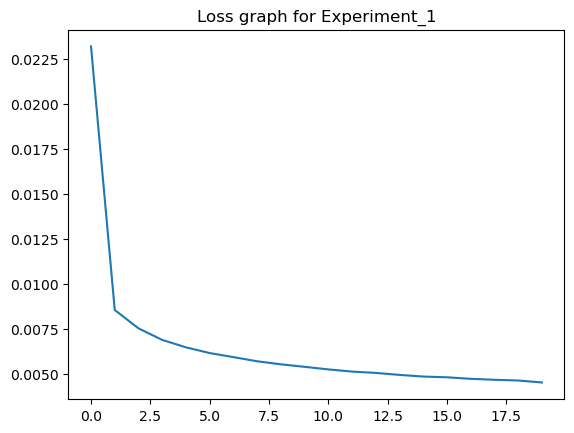

In [31]:
plt.figure()
plt.title(f"Loss graph for {experiment_id}")
plt.plot(hist_callback.history['loss'], label="loss")
plt.savefig(f'{model_path}/{model_id}_loss.svg', format='svg', dpi=1200)
plt.show()

# Quick validation set-up

Choose a trajectory from the dataset.
Visualize trajectory
use model to predict the same trajectory ( but in fewer steps! )
compare the 2 trajectory plots
# todo compare the loss or something
# todo save results of validation

In [32]:
dataset_to_predict = '72'
dataset_to_predict = '18'
x, y, vx, vy = tbp_util.load_dataset(dataset_to_predict)
print(x.shape)

(250000, 3)


In [33]:
length_to_predict = int(x.shape[0] / prediction_offset)
print(
    f"The original trajectory is T={x.shape[0]} time steps long, so we have to predict T/prediction_offset={x.shape[0]}/{prediction_offset}={length_to_predict} steps because we predict {prediction_offset} steps into the future.")

The original trajectory is T=250000 time steps long, so we have to predict T/prediction_offset=250000/10=25000 steps because we predict 10 steps into the future.


In [34]:
limit = length_to_predict
y_pred = np.zeros((limit, 12), dtype=np.float64)
y_pred[0,] = np.concatenate((x[0,], y[0,], vx[0,], vy[0,]))

In [35]:
for i in range(limit - 1):
    prediction = model(y_pred[i,].reshape(1, 12), training=False).numpy()

    # stop early when the system gets out of bounds
    if np.min(prediction[0, :6]) < -3 or np.max(prediction[0, :6]) > 3 or np.min(prediction) < -20 or np.max(
            prediction) > 20:
        print(f"Stop predicting at t={i * prediction_offset} ({i} steps) after encountering {prediction}")
        break

    y_pred[i + 1,] = prediction

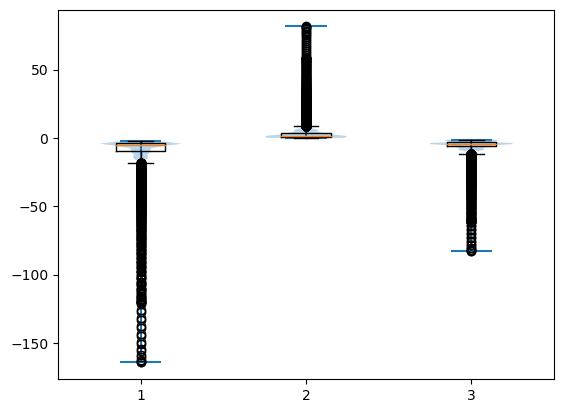

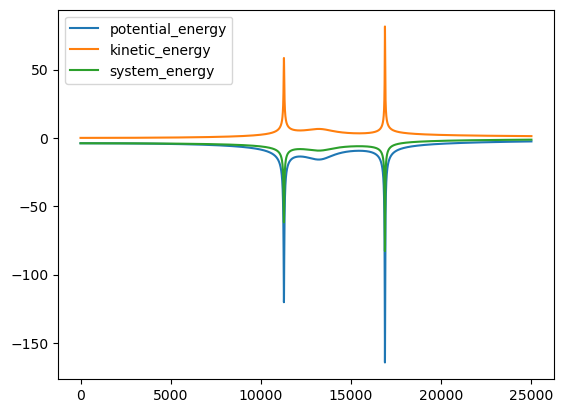

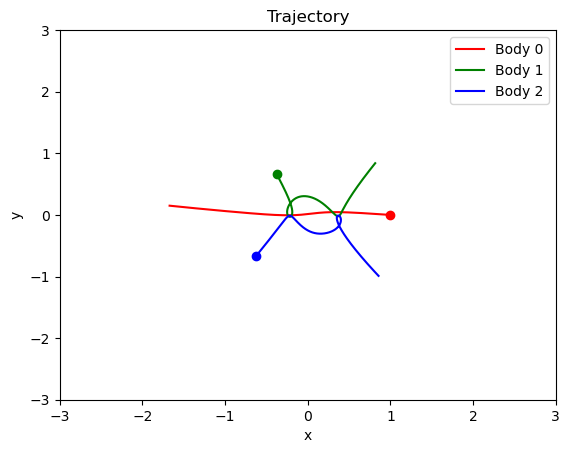

In [36]:
# Real trajectory
visualize_dataset(*tbp_util.load_dataset(dataset_to_predict), G, M, down_sample_factor=prediction_offset)

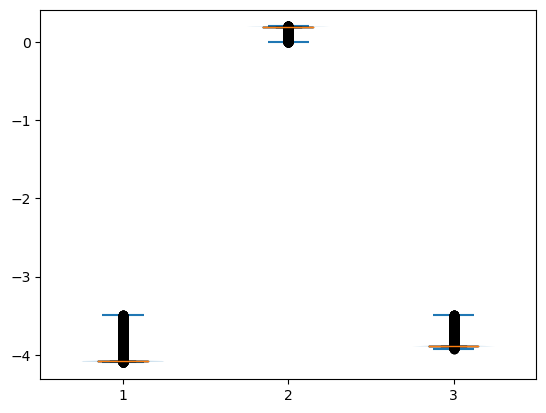

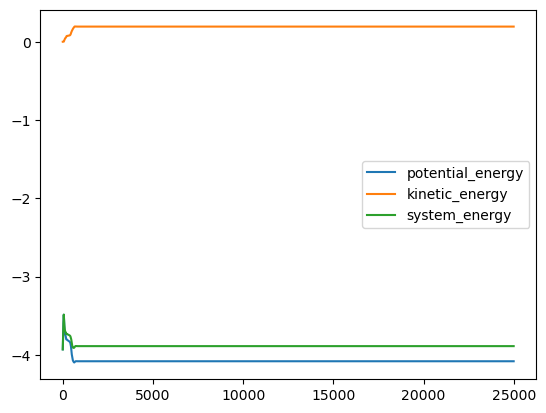

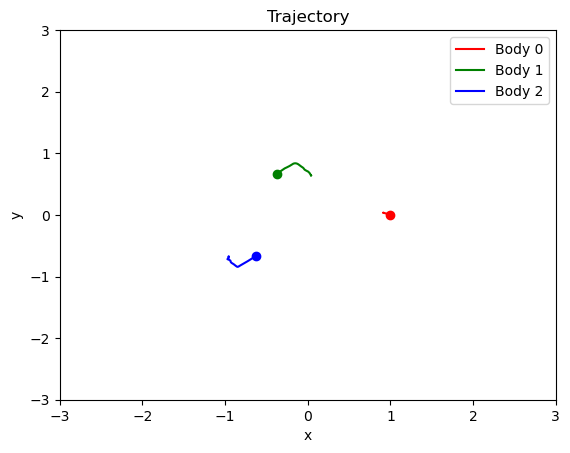

In [37]:
# Predicted trajectory
pred_x, pred_y, pred_vx, pred_vy = np.hsplit(y_pred, 4)
visualize_dataset(pred_x, pred_y, pred_vx, pred_vy, G, M, down_sample_factor=1)

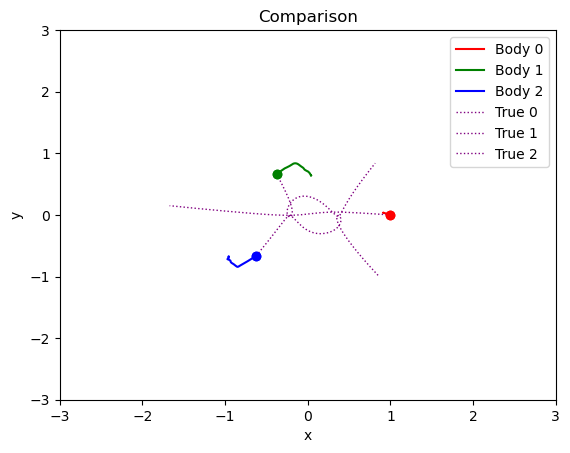

In [40]:
import Three_body_2D_Rick

# Comparison plot
true_x, true_y, _, _ = tbp_util.load_dataset(dataset_to_predict)
Three_body_2D_Rick.compare_plot(true_x, true_y, pred_x, pred_y,path=f'{model_path}/{model_id}', savefig=True)